# Logistic Regression

Implement logreg and apply it to different datasets.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils import *
import copy, math

%matplotlib inline

## Part 1 - Predict University Admittance

### Problem statement, shortened
You want to determine each applicants chane of admission based on their results on two exams.
- You have historical data from previous applicants to use as a training set for logistic regression.
- Each training example has the 2 scores and the admission decision.
- Build a classification model to estimate probability of admission based on their two scores.

### Load and visualize the data
Helper functions to load in data - 1 means the student was admitted, 0 means not.

In [7]:
def load_data(filename):
    data = np.loadtxt(filename, delimiter=',')
    X = data[:,:2]
    y = data[:,2]
    return X, y

X_train, y_train = load_data("data/ex2data1.txt")
print(f"First 5 elements:\n{X_train[:5]}")
print(f"First 5 results:\n{y_train[:5]}")
print(f"\nData dimentions: {X_train.shape}")

First 5 elements:
[[34.62365962 78.02469282]
 [30.28671077 43.89499752]
 [35.84740877 72.90219803]
 [60.18259939 86.3085521 ]
 [79.03273605 75.34437644]]
First 5 results:
[0. 0. 0. 1. 1.]

Data dimentions: (100, 2)


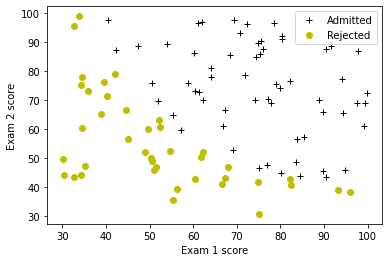

In [9]:
def plot_data(X, y, pos_label="y=1", neg_label="y=0"):
    positive = y == 1
    negative = y == 0
    
    # Plot examples
    plt.plot(X[positive, 0], X[positive, 1], 'k+', label=pos_label)
    plt.plot(X[negative, 0], X[negative, 1], 'yo', label=neg_label)
    

plot_data(X_train, y_train, pos_label="Admitted", neg_label="Rejected")
plt.ylabel("Exam 2 score")
plt.xlabel("Exam 1 score")
plt.legend(loc="upper right")
plt.show()

### Sigmoid

Model:
$f_{{\bf \vec w}, b}(\bf \vec x) = g({\bf \vec w \cdot \vec x} + b)$

Where:
$g(z) = \large \frac 1 {1 + e^{-z}}$


In [10]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

### Cost Function
Cost:
$$
J({\bf \vec w}, b) = \frac 1 m \sum_{i=1}^m \large [loss(f_{{\bf \vec w}, b}({\bf \vec x}^{(i)}, y^{(i)}]
$$

Where the loss function is that unholy long mess.

In [41]:
def compute_cost(X, y, w0, b0, lambda_=1):
    m, n = X.shape
    z = np.matmul(np.c_[X, np.ones(m)], np.r_[w0, b0])
    f_wb = sigmoid(z)
    cost = np.sum(-y * np.log(f_wb) - (1 - y) * np.log(1 - f_wb)) / m
    reg_cost = (lambda_ / (2 * m)) * np.sum(w ** 2)
    return cost + reg_cost

### Gradient for Logistic Regression

In [39]:
def compute_gradient(X, y, w, b, lambda_=None):
    m, n = X.shape
    z = np.matmul(np.c_[X, np.ones(m)], np.r_[w, b])
    f_wb = sigmoid(z)
    err = f_wb - y
    dj_db = np.sum(err) / m
    dj_dw = np.matmul(np.transpose(err), X) / m
    # Reg term
    dj_dw += (lambda_ / m) * w
    return dj_db, dj_dw

### Learning Parameters Using Gradient Descent

In [49]:
def gradient_descent(X, y, w, b, cost_function, gradient_function, alpha, num_iters, lambda_):
    m = len(X)
    J_hist = []
    w_hist = []
    for i in range(num_iters):
        dj_db, dj_dw = gradient_function(X, y, w, b, lambda_)
        w -= alpha * dj_dw - (w * lambda_ * alpha / m)
        b -= alpha * dj_db
        cost = cost_function(X, y, w, b, lambda_)
        J_hist.append(cost)
        if i % (num_iters // 100) == 0:
            w_hist.append(w)
            print(f"Iter {i:5d}:\t\tCost: {J_hist[-1]}")
    return w, b, J_hist, w_hist

In [50]:
np.random.seed(1)
w_in = 1e-2 * (np.random.rand(2).reshape(-1,) - 0.5)
b_in = -8

iterations = 10_000
alpha = 1e-3
w, b, J_hist, _ = gradient_descent(X_train, y_train, w_in, b_in, compute_cost, 
                                   compute_gradient, alpha, iterations, 0)

Iter     0:		Cost: 0.9637901832137509
Iter   100:		Cost: 0.30542318082768927
Iter   200:		Cost: 0.3053860974953493
Iter   300:		Cost: 0.3053490402383386
Iter   400:		Cost: 0.30531200757169474
Iter   500:		Cost: 0.3052749994706856
Iter   600:		Cost: 0.30523801591061395
Iter   700:		Cost: 0.3052010568668158
Iter   800:		Cost: 0.30516412231465984
Iter   900:		Cost: 0.30512721222954814
Iter  1000:		Cost: 0.30509032658691554
Iter  1100:		Cost: 0.30505346536222966
Iter  1200:		Cost: 0.30501662853099115
Iter  1300:		Cost: 0.30497981606873337
Iter  1400:		Cost: 0.30494302795102246
Iter  1500:		Cost: 0.3049062641534572
Iter  1600:		Cost: 0.3048695246516688
Iter  1700:		Cost: 0.30483280942132157
Iter  1800:		Cost: 0.3047961184381118
Iter  1900:		Cost: 0.30475945167776836
Iter  2000:		Cost: 0.30472280911605276
Iter  2100:		Cost: 0.3046861907287587
Iter  2200:		Cost: 0.30464959649171197
Iter  2300:		Cost: 0.3046130263807711
Iter  2400:		Cost: 0.3045764803718265
Iter  2500:		Cost: 0.304539958440800

Fuck it, entire util file in here

In [47]:
def map_feature(X1, X2):
    """
    Feature mapping function to polynomial features    
    """
    X1 = np.atleast_1d(X1)
    X2 = np.atleast_1d(X2)
    degree = 6
    out = []
    for i in range(1, degree+1):
        for j in range(i + 1):
            out.append((X1**(i-j) * (X2**j)))
    return np.stack(out, axis=1)


def plot_data(X, y, pos_label="y=1", neg_label="y=0"):
    positive = y == 1
    negative = y == 0
    
    # Plot examples
    plt.plot(X[positive, 0], X[positive, 1], 'k+', label=pos_label)
    plt.plot(X[negative, 0], X[negative, 1], 'yo', label=neg_label)
    
    
def plot_decision_boundary(w, b, X, y):
    # Credit to dibgerge on Github for this plotting code
     
    plot_data(X[:, 0:2], y)
    
    if X.shape[1] <= 2:
        plot_x = np.array([min(X[:, 0]), max(X[:, 0])])
        plot_y = (-1. / w[1]) * (w[0] * plot_x + b)
        
        plt.plot(plot_x, plot_y, c="b")
        
    else:
        u = np.linspace(-1, 1.5, 50)
        v = np.linspace(-1, 1.5, 50)
        
        z = np.zeros((len(u), len(v)))

        # Evaluate z = theta*x over the grid
        for i in range(len(u)):
            for j in range(len(v)):
                z[i,j] = sig(np.dot(map_feature(u[i], v[j]), w) + b)
        
        # important to transpose z before calling contour       
        z = z.T
        
        # Plot z = 0
        plt.contour(u,v,z, levels = [0.5], colors="g")

        
        

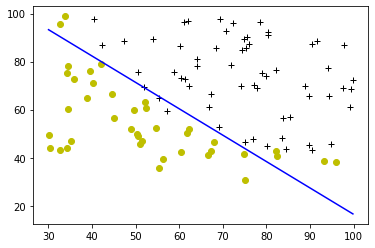

In [48]:
plot_decision_boundary(w, b, X_train, y_train)

### Evaluation
Predict and compare!

In [56]:
def predict(X, w, b):
    m = X.shape[0]
    z = np.matmul(
        np.c_[X, np.ones(m)],
        np.r_[w, b]
    )
    f_wb = sigmoid(z)
    p = f_wb >= 0.5
    return p

## Part 2 - Determine Microchip Quality
Pass or fail based on the test results in X
### Loading and Visualizing

Shape: (118, 2)
Sample: [[ 0.051267  0.69956 ]
 [-0.092742  0.68494 ]
 [-0.21371   0.69225 ]
 [-0.375     0.50219 ]
 [-0.51325   0.46564 ]]


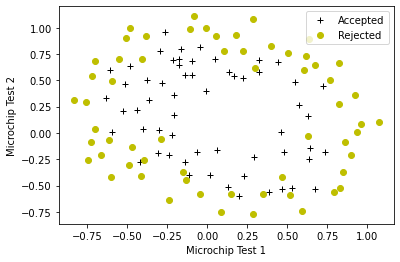

In [57]:
X_train, y_train = load_data('data/ex2data2.txt')
print(f"Shape: {X_train.shape}")
print(f"Sample: {X_train[:5]}")
plot_data(X_train, y_train[:], pos_label="Accepted", neg_label="Rejected")
plt.ylabel("Microchip Test 2")
plt.xlabel("Microchip Test 1")
plt.legend(loc="upper right")
plt.show()

### Feature Mapping

Looks like we can't easily separate the examples using a straight line.
We need to feature-map - without intuition, all polynomial terms of x1, x2 up to the...
6th power?? It's a circle, 2 should do it, surely?

Welp.
2-d feature array into 27-d, just like that.

In [59]:
mapped_X = map_feature(X_train[:, 0], X_train[:, 1])
print(f"New shape: {mapped_X.shape}")
print(f"\nSample: {mapped_X[0]}")

New shape: (118, 27)

Sample: [5.12670000e-02 6.99560000e-01 2.62830529e-03 3.58643425e-02
 4.89384194e-01 1.34745327e-04 1.83865725e-03 2.50892595e-02
 3.42353606e-01 6.90798869e-06 9.42624411e-05 1.28625106e-03
 1.75514423e-02 2.39496889e-01 3.54151856e-07 4.83255257e-06
 6.59422333e-05 8.99809795e-04 1.22782870e-02 1.67542444e-01
 1.81563032e-08 2.47750473e-07 3.38066048e-06 4.61305487e-05
 6.29470940e-04 8.58939846e-03 1.17205992e-01]


### Regularizing it all
Neat. Susceptible to overfitting though, look at those value ranges.
Alas, we're only using regularization here, not scaling, so...

In [60]:
def compute_cost_reg(X, y, w, b, lambda_=1):
    m = X.shape[0]
    cost = compute_cost(X, y, w, b, lambda_)
    cost_reg = np.sum(w ** 2)
    return cost + (lambda_ / (2 * m)) * cost_reg

In [61]:
def compute_gradient_reg(X, y, w, b, lambda_=1):
    m = X.shape[0]
    dj_dw_reg = (lambda_ * w) / m
    dj_db, dj_dw = compute_gradient(X, y, w, b, lambda_)
    return dj_db, dj_dw + dj_dw_reg